# Machine Learning - Assignment 2

## Decision tree induction algorithm for classification tasks

The aim of the assignment is to:

* Implement a decision tree induction algorithm for classification tasks.
* Make sure it works for real valued features and nominal features (categorical features without rank, e.g., red - blue - green).
* Test the algorithm on 3 datasets.

Follow the instructions and implement what is missing to complete the assignment. Some functions have been started to help you a little bit with the inputs or outputs of the function.

**Note:** You might need to go back and forth during your implementation of the code. The structure is set up to make implementation easier, but how you return values from the different functions might vary, and you might find yourself going back and change something to make it easier later on.

## Assignment preparations

We help you out with importing the libraries.

**IMPORTANT NOTE:** You may not import any more libraries than the ones already imported!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

## Decision tree model

The main objective is to implement the decision tree model. The implemented decision tree needs to be recursive model, that is, it should be implemented general enough to call itself in order to grow. "Growing" a tree refers to the same thing as "training" a model.

As said in the introduction, the structure is set up to help with implementation, but the nature of this model makes it a bit harder to implement function-by-function. You will most likely go back and forth between these first tasks.

### 1) Grow Tree

We will start with the main function of the decision tree, the "growing" function. 

This function should be called when creating the model, but also from inside itself. It is responible for creating all the nodes and leafs in the tree.

In [2]:
def grow_tree(data, min_samples_split=2, max_depth=2, depth=0):
    X, Y = data[:, :-1], data[:, -1]
    n_samples, n_features = np.shape(X)

    if (single_class_stop(Y) or max_depth_stop(max_depth, depth) or min_split_stop(Y, min_samples_split) or is_imbalanced_stop(Y)):
        return {"value": max(set(Y), key=list(Y).count)}

    gini_split = gini_impurity_split(data, n_features)

    if gini_split["info_gain"] > 0:
        left_subtree = grow_tree(gini_split["dataset_left"], min_samples_split, max_depth, depth + 1)
        right_subtree = grow_tree(gini_split["dataset_right"], min_samples_split, max_depth, depth + 1)

        return {
            "feature_index": gini_split["feature_index"],
            "threshold": gini_split["threshold"],
            "left": left_subtree,
            "right": right_subtree,
            "info_gain": gini_split["info_gain"]
        }

    return {"value": max(set(Y), key=list(Y).count)}

### 2) Growth stopping conditions (or stopping criterias)

The "grow_tree" function needs some way of stop growing, otherwise it will grow indefinitely. We will adress this issue here.

The trees stopping criterias needs to handle the following:

1) When a node has only datapoints of a single class.

2) Prevent the tree from growing to large, i.e., a max depth.

3) Prevent the tree nodes from becoming to small.

4) Prevent the tree from growing when the node is large (has a lot of datapoints) but it is very unbalanced. This is an extention to case 1.

Can you think of some other stopping criterias that is good to have? 

In [3]:
def single_class_stop(features):
    unique_features, counts = np.unique(features, return_counts=True)
    if len(unique_features) == 1:
        return True
    return False

def max_depth_stop(max_depth, depth):
    if depth >= max_depth:
        return True
    return False

def min_split_stop(features, min_samples_split):
    if len(features) < min_samples_split:
        return True
    return False

def is_imbalanced_stop(Y):
    Y = Y.astype(int)
    imbalance_threshold = 0.9
    max_class_ratio = np.max(np.bincount(Y)) / len(Y)
    if max_class_ratio >= imbalance_threshold:
        return True
    return False

### 3) Best feature for splitting nodes

When we are growing the tree, we need to decide how we are going to split a node into two new nodes. This is achived by looking at the features of the data in the node and calculate the best feature to split on.

Here you have a choice:

* Split using **Information Entropy**
* Split using **Gini Impurity**

Finish the function below using Information Entropy or Gini Impurity.

**Note:** Your code should be able to handle both real and categorical features!

In [4]:
# TODO: Change the name to which ever you chose.
def gini_impurity_split(dataset, n_features):
    gini_split = None
    max_info_gain = -float("inf")

    for feature_index in range(n_features):

        feature_values = dataset[:, feature_index]

        is_numerical = np.issubdtype(feature_values.dtype, np.number)

        if is_numerical:
            possible_thresholds = [np.mean(feature_values)]
        else:
            possible_thresholds = np.unique(feature_values)

        for threshold in possible_thresholds:
            dataset_left, dataset_right = split_data(dataset, feature_index, threshold)
            if len(dataset_left) > 0 and len(dataset_right) > 0:
                parent = dataset[:, -1]
                left_child = dataset_left[:, -1]
                right_child = dataset_right[:, -1]

                parent_gini = 1 - sum([(np.sum(parent == label) / len(parent)) ** 2 for label in np.unique(parent)])
                left_gini = 1 - sum([(np.sum(left_child == label) / len(left_child)) ** 2 for label in np.unique(left_child)])
                right_gini = 1 - sum([(np.sum(right_child == label) / len(right_child)) ** 2 for label in np.unique(right_child)])

                weight_left = len(left_child) / len(parent)
                weight_right = len(right_child) / len(parent)
                weighted_gini = (weight_left * left_gini + weight_right * right_gini)

                gain = parent_gini - weighted_gini
                if gain > max_info_gain:
                    gini_split = {
                        "feature_index": feature_index,
                        "threshold": threshold,
                        "dataset_left": dataset_left,
                        "dataset_right": dataset_right,
                        "info_gain": gain
                    }
                    max_info_gain = gain

    return gini_split

### 4) Split data

When growing the tree, we need to split the data multiple times, and what we decide to split varies a lot. It is similar to splitting data into train and test sets (remember from assignment 1), but we split the data based on the best feature for growing a good tree.

**IMPORTANT NOTE:** To calculate binary splits for real-valued features, the following rule must be applied: an instance with a feature value lower than the mean feature value follows the left edge from the split node while all other instances follow the right edge from the split node.

In [5]:
def split_data(dataset, feature_index,threshold):
    
    feature_values = dataset[:, feature_index]
    is_numerical = np.issubdtype(feature_values.dtype, np.number)

    if is_numerical:
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
    else:
        dataset_left = np.array([row for row in dataset if row[feature_index] == threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] != threshold])

    return dataset_left, dataset_right

### 5) Predict with tree model

Finally, when we have grown our tree, we would like to use it for prediction. When using the tree for prediction, we traverse the tree for each datapoint untill we land in a leaf node.

In [6]:
def predict_with_tree(X, tree):
    predictions = []
    
    for x in X:
        
        current_node = tree
        while current_node.get("value") is None:
            feature_val = x[current_node["feature_index"]]

            if feature_val <= current_node["threshold"]:
                current_node = current_node["left"]

            else:
                current_node = current_node["right"]
        
        predictions.append(current_node["value"])
    return predictions

## Test decision tree model, compare with scikit learn, and plot dataset results

In the last part of the lab, you are going to test your tree code and compare it to scikit learn. The goal is not to be better than an established library, but to give you an indication about if you are on the right track.

You will need to plot the results from your model and the scikit learn model using matplotlib. We suggest a simple but informative bar-charts.

To make the comparison fair, you should train and test both your decision tree algorithm and the scikit learn at least 5 times, and shuffle the data each time before splitting the data into a train and test set.

The datasets are:

* Wine - (https://archive.ics.uci.edu/dataset/109/wine)
* Heart disease - (https://archive.ics.uci.edu/dataset/45/heart+disease)
* Car - (https://archive.ics.uci.edu/dataset/19/car+evaluation)

**IMPORTANT NOTE 1:** Take note of the feature types in the datasets, some features are numerical in value but are in fact categorical features. Be sure to handle these features correctly!

**IMPORTANT NOTE 2:** In this assignment it helps to add an additional header with information about the features and if they are nominal (n) or real (r) features.

You may use the "**accuracy_score**" function from scikit learn (imported above) to compare the performance of your own and scikit learns models.

See below for an example use.

In [7]:
y_true = [1,1,1,1,1] # Pretend labels
y_pred = [1,1,2,2,1] # Pretend prediction

accuracy_score(y_true, y_pred)

0.6

### 6) Dataset 1: Wine

Wine Dataset Decision Tree

Run 1:
Custom Decision Tree : 0.857
Scikit-Learn Decision Tree: 0.914

Run 2:
Custom Decision Tree : 0.800
Scikit-Learn Decision Tree: 0.829

Run 3:
Custom Decision Tree : 0.943
Scikit-Learn Decision Tree: 0.857

Run 4:
Custom Decision Tree : 0.886
Scikit-Learn Decision Tree: 0.829

Run 5:
Custom Decision Tree : 1.000
Scikit-Learn Decision Tree: 1.000

Average Accuracy Results:
Custom Decision Tree: 0.897
Scikit-Learn Decision Tree: 0.886


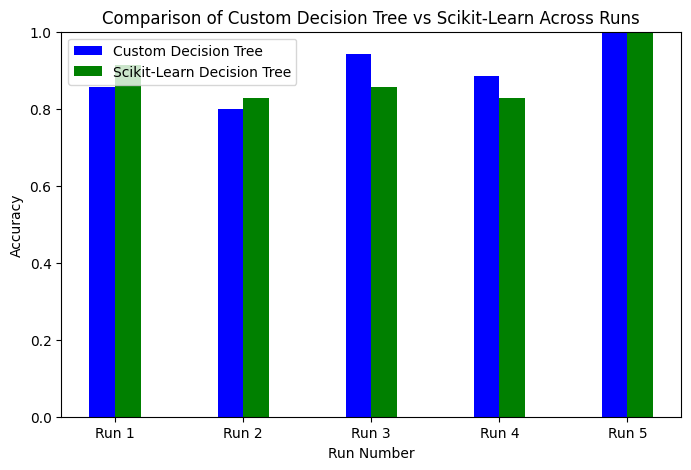

In [8]:
data_wine = pd.read_csv("wine.csv")
data_wine=data_wine.drop(0)

custom_tree_accuracies = []
sklearn_tree_accuracies = []

print("Wine Dataset Decision Tree")

for i in range(5):

    data_wine = data_wine.sample(frac=1).reset_index(drop=True)
    data_wine = data_wine.astype(float)
    X = data_wine.iloc[:, :-1].values
    Y = data_wine.iloc[:, -1].values.reshape(-1, 1)

    split_size = int(0.2 * len(data_wine))

    # Split into train and test sets
    X_test, Y_test = X[:split_size], Y[:split_size]
    X_train, Y_train = X[split_size:], Y[split_size:]


    training_wine_data=np.concatenate((X_train, Y_train), axis=1)
    
    tree = grow_tree(training_wine_data, min_samples_split=3, max_depth=4)

    Y_pred_custom = predict_with_tree(X_test, tree)


    accuracy_custom = accuracy_score(Y_test, Y_pred_custom)
    custom_tree_accuracies.append(accuracy_custom)

    sk_tree = DecisionTreeClassifier(max_depth=4, min_samples_split=3)
    sk_tree.fit(X_train, Y_train)
    Y_pred_sk = sk_tree.predict(X_test)

    accuracy_sk = accuracy_score(Y_test, Y_pred_sk)
    sklearn_tree_accuracies.append(accuracy_sk)

    print(f"\nRun {i+1}:")
    print(f"Custom Decision Tree : {accuracy_custom:.3f}")
    print(f"Scikit-Learn Decision Tree: {accuracy_sk:.3f}")


print("\nAverage Accuracy Results:")
print(f"Custom Decision Tree: {np.mean(custom_tree_accuracies):.3f}")
print(f"Scikit-Learn Decision Tree: {np.mean(sklearn_tree_accuracies):.3f}")

x_labels = [f"Run {i+1}" for i in range(5)]
x = np.arange(len(x_labels))
width = 0.2

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, custom_tree_accuracies, width, label="Custom Decision Tree", color="blue")
plt.bar(x + width/2, sklearn_tree_accuracies, width, label="Scikit-Learn Decision Tree", color="green")

plt.xlabel("Run Number")
plt.ylabel("Accuracy")
plt.title("Comparison of Custom Decision Tree vs Scikit-Learn Across Runs")
plt.xticks(x, x_labels)
plt.ylim(0, 1)
plt.legend()

plt.show()

### 7) Dataset 2: Heart Disease

Heart Dataset Decision Tree

Run 1:
Custom Decision Tree : 0.863
Scikit-Learn Decision Tree: 0.819

Run 2:
Custom Decision Tree : 0.809
Scikit-Learn Decision Tree: 0.794

Run 3:
Custom Decision Tree : 0.824
Scikit-Learn Decision Tree: 0.843

Run 4:
Custom Decision Tree : 0.794
Scikit-Learn Decision Tree: 0.819

Run 5:
Custom Decision Tree : 0.868
Scikit-Learn Decision Tree: 0.853

Average Accuracy Results:
Custom Decision Tree: 0.831
Scikit-Learn Decision Tree: 0.825


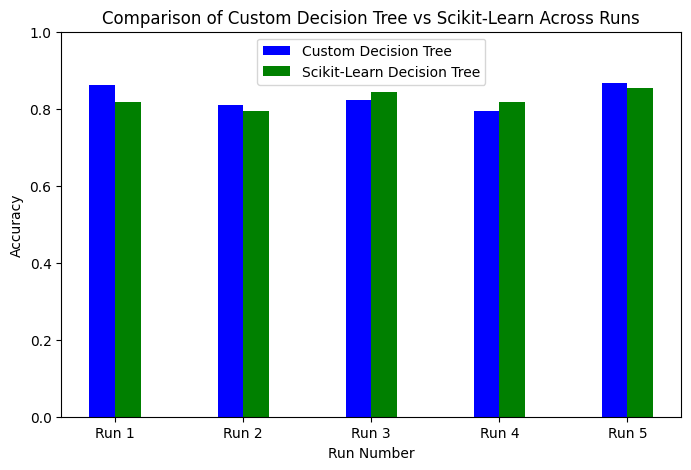

In [9]:
data_heart = pd.read_csv("heart.csv")
data_heart=data_heart.drop(0)

custom_tree_accuracies = []
sklearn_tree_accuracies = []

print("Heart Dataset Decision Tree")

for i in range(5):

    data_heart = data_heart.sample(frac=1).reset_index(drop=True)

    X = data_heart.iloc[:, :-1].values
    Y = data_heart.iloc[:, -1].values.reshape(-1, 1)

    split_size = int(0.2 * len(data_heart))

    X_test, Y_test = X[:split_size], Y[:split_size]
    X_train, Y_train = X[split_size:], Y[split_size:]


    training_heart_data=np.concatenate((X_train, Y_train), axis=1)
    tree = grow_tree(training_heart_data, min_samples_split=3, max_depth=4)

    Y_pred_custom = predict_with_tree(X_test, tree)


    accuracy_custom = accuracy_score(Y_test, Y_pred_custom)
    custom_tree_accuracies.append(accuracy_custom)

    sk_tree = DecisionTreeClassifier(max_depth=4, min_samples_split=3)
    sk_tree.fit(X_train, Y_train)
    Y_pred_sk = sk_tree.predict(X_test)

    accuracy_sk = accuracy_score(Y_test, Y_pred_sk)
    sklearn_tree_accuracies.append(accuracy_sk)

    print(f"\nRun {i+1}:")
    print(f"Custom Decision Tree : {accuracy_custom:.3f}")
    print(f"Scikit-Learn Decision Tree: {accuracy_sk:.3f}")

print("\nAverage Accuracy Results:")
print(f"Custom Decision Tree: {np.mean(custom_tree_accuracies):.3f}")
print(f"Scikit-Learn Decision Tree: {np.mean(sklearn_tree_accuracies):.3f}")

x_labels = [f"Run {i+1}" for i in range(5)]
x = np.arange(len(x_labels))
width = 0.2

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, custom_tree_accuracies, width, label="Custom Decision Tree", color="blue")
plt.bar(x + width/2, sklearn_tree_accuracies, width, label="Scikit-Learn Decision Tree", color="green")

plt.xlabel("Run Number")
plt.ylabel("Accuracy")
plt.title("Comparison of Custom Decision Tree vs Scikit-Learn Across Runs")
plt.xticks(x, x_labels)
plt.ylim(0, 1)
plt.legend()

plt.show()

### 8) Dataset 3: Car

Car Dataset Decision Tree

Run 1:
Custom Decision Tree : 0.806
Scikit-Learn Decision Tree: 0.814

Run 2:
Custom Decision Tree : 0.814
Scikit-Learn Decision Tree: 0.843

Run 3:
Custom Decision Tree : 0.814
Scikit-Learn Decision Tree: 0.826

Run 4:
Custom Decision Tree : 0.843
Scikit-Learn Decision Tree: 0.846

Run 5:
Custom Decision Tree : 0.806
Scikit-Learn Decision Tree: 0.817

Average Accuracy Results:
Custom Decision Tree: 0.817
Scikit-Learn Decision Tree: 0.830


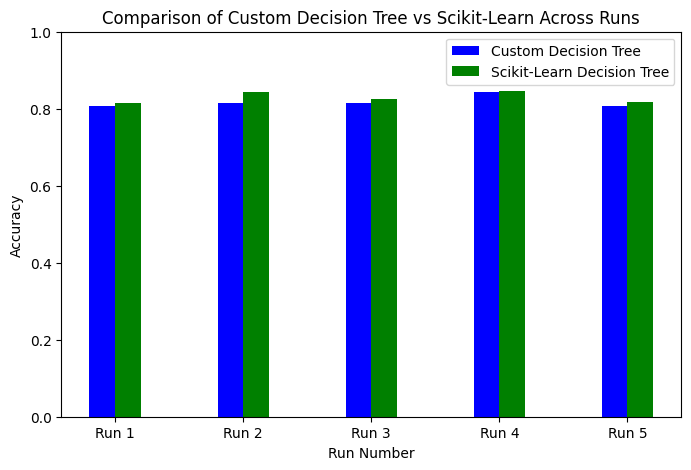

In [10]:
data_car = pd.read_csv("car.csv")
data_car = data_car.drop(0)

label_encoders = {}
for col in data_car.columns:
    le = LabelEncoder()
    data_car[col] = le.fit_transform(data_car[col])
    label_encoders[col] = le

custom_tree_accuracies = []
sklearn_tree_accuracies = []

print("Car Dataset Decision Tree")

for i in range(5):

    data_car = data_car.sample(frac=1).reset_index(drop=True)

    X = data_car.iloc[:, :-1].values
    Y = data_car.iloc[:, -1].values.reshape(-1, 1)

    split_size = int(0.2 * len(data_car))

    X_test, Y_test = X[:split_size], Y[:split_size]
    X_train, Y_train = X[split_size:], Y[split_size:]

    training_car_data = np.concatenate((X_train, Y_train), axis=1)

    tree = grow_tree(training_car_data, min_samples_split=3, max_depth=4)
    Y_pred_custom = predict_with_tree(X_test, tree)

    accuracy_custom = accuracy_score(Y_test, Y_pred_custom)
    custom_tree_accuracies.append(accuracy_custom)
    
    sk_tree = DecisionTreeClassifier(max_depth=4, min_samples_split=3)
    sk_tree.fit(X_train, Y_train.ravel()) 
    Y_pred_sk = sk_tree.predict(X_test)

    accuracy_sk = accuracy_score(Y_test, Y_pred_sk)
    sklearn_tree_accuracies.append(accuracy_sk)

    print(f"\nRun {i+1}:")
    print(f"Custom Decision Tree : {accuracy_custom:.3f}")
    print(f"Scikit-Learn Decision Tree: {accuracy_sk:.3f}")

print("\nAverage Accuracy Results:")
print(f"Custom Decision Tree: {np.mean(custom_tree_accuracies):.3f}")
print(f"Scikit-Learn Decision Tree: {np.mean(sklearn_tree_accuracies):.3f}")

x_labels = [f"Run {i+1}" for i in range(5)]
x = np.arange(len(x_labels))
width = 0.2

plt.figure(figsize=(8, 5))
plt.bar(x - width/2, custom_tree_accuracies, width, label="Custom Decision Tree", color="blue")
plt.bar(x + width/2, sklearn_tree_accuracies, width, label="Scikit-Learn Decision Tree", color="green")

plt.xlabel("Run Number")
plt.ylabel("Accuracy")
plt.title("Comparison of Custom Decision Tree vs Scikit-Learn Across Runs")
plt.xticks(x, x_labels)
plt.ylim(0, 1)
plt.legend()

plt.show()

### 9) Training with normalized data on the wine-dataset

So far, we have trained our decision trees with "raw" data, i.e., we haven't done much preprocessing on the data.

Here we will do minor preprocessing on the data with the help of the scikit-learn library: https://scikit-learn.org/stable/modules/preprocessing.html

Wine Dataset Decision Tree - Preprocessed vs Non-Preprocessed

Run 1:
Custom Decision Tree (Non-Preprocessed): 0.914
Scikit-Learn Decision Tree (Non-Preprocessed): 0.943
Custom Decision Tree (Preprocessed): 0.914
Scikit-Learn Decision Tree (Preprocessed): 0.943

Run 2:
Custom Decision Tree (Non-Preprocessed): 0.829
Scikit-Learn Decision Tree (Non-Preprocessed): 0.943
Custom Decision Tree (Preprocessed): 0.829
Scikit-Learn Decision Tree (Preprocessed): 0.943

Run 3:
Custom Decision Tree (Non-Preprocessed): 0.914
Scikit-Learn Decision Tree (Non-Preprocessed): 0.771
Custom Decision Tree (Preprocessed): 0.914
Scikit-Learn Decision Tree (Preprocessed): 0.886

Run 4:
Custom Decision Tree (Non-Preprocessed): 0.914
Scikit-Learn Decision Tree (Non-Preprocessed): 0.971
Custom Decision Tree (Preprocessed): 0.914
Scikit-Learn Decision Tree (Preprocessed): 0.971

Run 5:
Custom Decision Tree (Non-Preprocessed): 0.914
Scikit-Learn Decision Tree (Non-Preprocessed): 0.943
Custom Decision Tree (Preproce

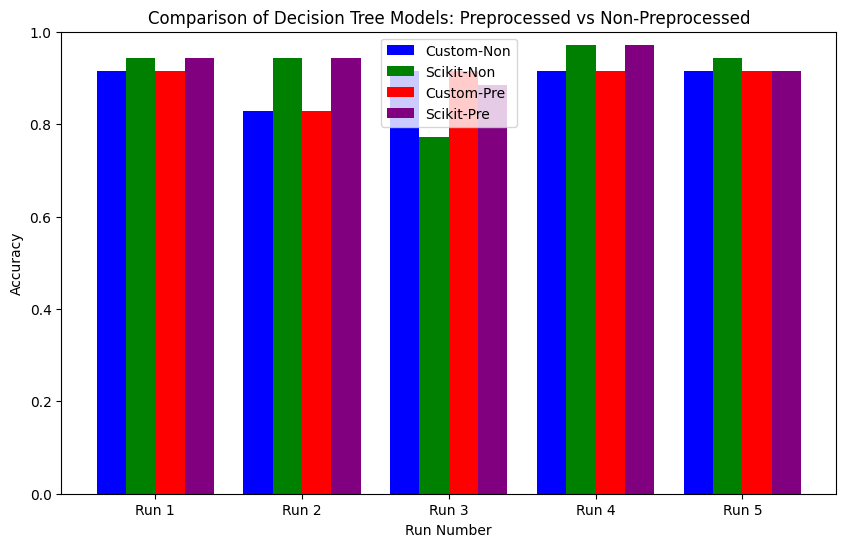

In [11]:
data_wine = pd.read_csv("wine.csv")
data_wine=data_wine.drop(0)

custom_non_preprocessed_accuracies = []
sklearn_non_preprocessed_accuracies = []
custom_preprocessed_accuracies = []
sklearn_preprocessed_accuracies = []


scaler_X = MinMaxScaler()

print("Wine Dataset Decision Tree - Preprocessed vs Non-Preprocessed")

for i in range(5):
    data_wine = data_wine.sample(frac=1).reset_index(drop=True)
    data_wine = data_wine.astype(float)
    
    X = data_wine.iloc[:, :-1].values
    Y = data_wine.iloc[:, -1].values.reshape(-1, 1)

    split_size = int(0.2 * len(data_wine))
    
    X_test, Y_test = X[:split_size], Y[:split_size]
    X_train, Y_train = X[split_size:], Y[split_size:]

    training_wine_data=np.concatenate((X_train, Y_train), axis=1)
    
    tree = grow_tree(training_wine_data, min_samples_split=3, max_depth=4)
    Y_pred_custom = predict_with_tree(X_test, tree)
    
    accuracy_custom = accuracy_score(Y_test, Y_pred_custom)
    custom_non_preprocessed_accuracies.append(accuracy_custom)

    sk_tree = DecisionTreeClassifier(max_depth=4, min_samples_split=3)
    sk_tree.fit(X_train, Y_train)
    accuracy_sk = accuracy_score(Y_test, sk_tree.predict(X_test))
    sklearn_non_preprocessed_accuracies.append(accuracy_sk)
    #Scaling
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    training_scale_wine_data=np.concatenate((X_train_scaled, Y_train), axis=1)

    tree_scaled = grow_tree(training_scale_wine_data, min_samples_split=3, max_depth=4)
    Y_pred_custom_scaled = predict_with_tree(X_test_scaled, tree_scaled)
    accuracy_custom_scaled = accuracy_score(Y_test, Y_pred_custom_scaled)   
    custom_preprocessed_accuracies.append(accuracy_custom_scaled)

    sk_tree_scaled = DecisionTreeClassifier(max_depth=4, min_samples_split=3)
    sk_tree_scaled.fit(X_train_scaled, Y_train)
    accuracy_sk_scaled = accuracy_score(Y_test, sk_tree_scaled.predict(X_test_scaled))
    sklearn_preprocessed_accuracies.append(accuracy_sk_scaled)

    print(f"\nRun {i+1}:")
    print(f"Custom Decision Tree (Non-Preprocessed): {accuracy_custom:.3f}")
    print(f"Scikit-Learn Decision Tree (Non-Preprocessed): {accuracy_sk:.3f}")
    print(f"Custom Decision Tree (Preprocessed): {accuracy_custom_scaled:.3f}")
    print(f"Scikit-Learn Decision Tree (Preprocessed): {accuracy_sk_scaled:.3f}")

print("\nFinal Accuracy Results:")
print(f"Custom Decision Tree (Non-Preprocessed): {np.mean(custom_non_preprocessed_accuracies):.3f}")
print(f"Scikit-Learn Decision Tree (Non-Preprocessed): {np.mean(sklearn_non_preprocessed_accuracies):.3f}")
print(f"Custom Decision Tree (Preprocessed): {np.mean(custom_preprocessed_accuracies):.3f}")
print(f"Scikit-Learn Decision Tree (Preprocessed): {np.mean(sklearn_preprocessed_accuracies):.3f}")


x_labels = [f"Run {i+1}" for i in range(5)]
x = np.arange(len(x_labels))
width = 0.2

plt.figure(figsize=(10, 6))

plt.bar(x - 1.5 * width, custom_non_preprocessed_accuracies, width, label="Custom-Non", color="blue")
plt.bar(x - 0.5 * width, sklearn_non_preprocessed_accuracies, width, label="Scikit-Non", color="green")
plt.bar(x + 0.5 * width, custom_preprocessed_accuracies, width, label="Custom-Pre", color="red")
plt.bar(x + 1.5 * width, sklearn_preprocessed_accuracies, width, label="Scikit-Pre", color="purple")

plt.xlabel("Run Number")
plt.ylabel("Accuracy")
plt.title("Comparison of Decision Tree Models: Preprocessed vs Non-Preprocessed")
plt.xticks(x, x_labels)
plt.ylim(0, 1)
plt.legend()
plt.show()

# Questions for examination:

In addition to completing the assignment with all its tasks, you should also prepare to answer the following questions:

1) Why is it called "naive bayes"?
<br>Ans : The Naive Bayes algorithm is an implementation of the traditional Bayes Theorem which was named after `Reverend Thomas Bayes` who studied Binomial Distributions and their probabilities and hence the model that implemented this algorithm was also named Naive Bayes after `Reverend Thomas Bayes`. The term `Naive`came into the name because of the independence assumtions made to reach the theorem which at that time was considered a 'Naive' approach.

2) What are some downsides of the naive bayes learning algorithm?
<br>Ans : The Naive Bayes algorithm has the following demerits to it : 
    - Conditional Independence Assumption : The assumptions about independence made in the algorithm doesn't always hold in real life situations
    - Zero Probability Problem : Any words encountered in the test data that aren't in the training data results in class probability value of zero

3) When using ROC-curves, what is the theoretical best and worst result you can get?
<br>Ans : Theoretically, the best ROC curve would have a curve score of 1.0. This is the case where the predictions exactly match with actual values for all tested values within and outside the testing data. The worst case would be a curve score of 0.5. This would be the equivalent of randomly guessing the outcome.

4) When using ROC-curves, in this assignment for example, is a higher threshold-stepsize always better?  
<br>Ans : No, a smaller threshold step size would provide a smoother ROC curve but it could possibly increase the computational time, but inversely, a larger threshold step size would reduce precision but can complete computations faster. This is usually dynamic and can vary based on the dataset used.

5) When using cross-validation and ROC-curves, why is it important to take the correct mean values? What could go wrong?
<br>Ans : Compared to numeric representations, ROC curves can represent the average performance of the model over each folds of cross validation in a more visually pleasing and understandable method and hence is helpful for a human analyst.
This can be offset by incorrect mean values since incorrect mean values can grossly misrepresent the true performance of the model, often leading to wrongly reached conclusions about the model's effectiveness.

# Finished!

Was part of the setup incorrect? Did you spot any inconsistencies in the assignment? Could something improve?

If so, please write them and send via email and send it to:

* marcus.gullstrand@ju.se

Thank you!